In [9]:
# pip install pandas
# pip install webcolors
# pip install seaborn

In [ ]:
# confusion matrix **
# train/val random 10개 뽑아서 5장 이미지 5장 마스크 5장 이미지 5장 마스크 **
# test random 10개 뽑아서 5장 이미지 5장 마스크 5장 이미지 5장 마스크 **
# class별 val mIoU
# easydict

import os
import random
import argparse
import cv2
import numpy as np
import pandas as pd
import webcolors
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp
from torchvision import models
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pytorch_lightning as pl
from transform import make_transform
from model import SmpModel
from datasets import PoseDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torchvision import models
from torchsummary import summary

In [3]:
train_path = 'data/train'
val_path = 'data/val'
# test_path = 'test'
batch_size = 1

class_colormap = pd.DataFrame({'name': ['background',
                'body',
                'R-hand',
                'L-hand',
                'L-foot',
                'R-foot',
                'R-thigh',
                'L-thigh',
                'R-calf',
                'L-calf',
                'L-arm',
                'R-arm',
                'L-forearm',
                'R-forearm',
                'head'],
                 'r': [0, 192, 0  , 0  , 128, 64 , 64 , 192, 192, 64 , 128, 0  , 0  , 64 , 192],
                 'g': [0, 0  , 128, 128, 0  , 0  , 0  , 128, 192, 64 , 0  , 0  , 128, 128, 192],
                 'b': [0, 128, 192, 64 , 0  , 128, 192, 64 , 128, 128, 192, 128, 0  , 192, 192]})

category_names = ['background', 'body','R-hand', 'L-hand','L-foot','R-foot', 'R-thigh', 'L-thigh',  'R-calf','L-calf',  'L-arm', 'R-arm', 'L-forearm','R-forearm','head']

def collate_fn(batch):
    return tuple(zip(*batch))

########################### DataLoader define ###########################
    
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((15, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):

    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

########################### mIoU 계산 ###########################
    
def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc, iu

def add_hist(hist, label_trues, label_preds, n_class):
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    return hist

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist
        
def draw_confusion_matrix(cf_matrix, save_dir = 'confusion_matrix.png'):
    fig, ax = plt.subplots(figsize=(10,10))
    a=cf_matrix.astype('float')/cf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(a, index = category_names, columns = category_names)
    sns.heatmap(df_cm.round(2), annot = True, cmap = plt.cm.Blues)
    plt.savefig(save_dir)
    
########################### mIoU추출 ###########################        

def extract_best_mIoU(index, now_mIoU, mIoU_list, best_img_list):
    temp_miou = []
    temp_img = []
    skip = True
    for i in range(10):
        if now_mIoU >= mIoU_list[i] and skip:
            temp_miou.append(now_mIoU)
            temp_img.append(index)
            skip = False
        temp_miou.append(mIoU_list[i])
        temp_img.append(best_img_list[i])
    return temp_miou[:10], temp_img[:10]


def extract_worst_mIoU(index, now_mIoU, mIoU_list, best_img_list):
    temp_miou = []
    temp_img = []
    skip = True
    for i in range(10):
        if now_mIoU <= mIoU_list[i] and skip:
            temp_miou.append(now_mIoU)
            temp_img.append(index)
            skip = False
        temp_miou.append(mIoU_list[i])
        temp_img.append(best_img_list[i])
    return temp_miou[:10], temp_img[:10]

########################### Main 함수 ###########################

def main(model, 
         data_dir = train_path, 
         mode = 'train',
         n_class = 15,
         confusion_matrix= True, 
         save_image_pred = True, 
         mIoU_print = True):
    if mode not in ('train','val'):
        raise print('using train or val dataset')
    
    mIoU_best10 = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10 = [99,99,99,99,99,99,99,99,99,99]
    mIoU_best10_imageid = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10_imageid = [0,0,0,0,0,0,0,0,0,0]
    
    dataset = PoseDataset(data_dir=data_dir, mode=mode, transform=A.Compose([ToTensorV2()]))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = 1, num_workers=4, collate_fn=collate_fn)    
    
    hist = np.zeros((n_class, n_class))
    with torch.no_grad():
        for index, (data) in tqdm(enumerate(loader)):
            img_hist = np.zeros((n_class, n_class))
            temp_images, temp_masks = data
            model.eval()
            
            outs = model(torch.stack(temp_images).to(device))#['out']
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
            masks = torch.stack(temp_masks).numpy()
            
            if mode in ('train','val') and confusion_matrix:
                if index == 0 : 
                    cf_matrix = sklearn.metrics.confusion_matrix(np.ndarray.flatten(masks),
                                                  np.ndarray.flatten(oms[0]),
                                                  labels=list(range(n_class)))
                else : 
                    cf_matrix += sklearn.metrics.confusion_matrix(np.ndarray.flatten(masks),
                                                  np.ndarray.flatten(oms[0]),
                                                  labels=list(range(n_class)))
                    
            if mIoU_print:
                
                img_hist = add_hist(img_hist, masks, oms, n_class=n_class)
                img_hist = add_hist(img_hist, masks, oms, n_class=n_class)
                hist = add_hist(hist, masks, oms, n_class=n_class)
                _, _, img_mIoU, _, _ = label_accuracy_score(img_hist)
                
                if img_mIoU > mIoU_best10[-1]: 
                    mIoU_best10,mIoU_best10_imageid = extract_best_mIoU(index,img_mIoU,mIoU_best10,mIoU_best10_imageid)
                if img_mIoU < mIoU_worst10[-1]: 
                    mIoU_worst10,mIoU_worst10_imageid = extract_worst_mIoU(index,img_mIoU,mIoU_worst10,mIoU_worst10_imageid)
                    
        if confusion_matrix:
            draw_confusion_matrix(cf_matrix,'confusion_matrix.png')

        if mIoU_print:
            _, _, mIoU, _, _ = label_accuracy_score(hist)
    
    return mIoU, mIoU_best10, mIoU_best10_imageid, mIoU_worst10, mIoU_worst10_imageid

In [66]:
512*512

262144

In [42]:
dataset = PoseDataset(data_dir='data/train', mode='train', transform=A.Compose([ToTensorV2()]))
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = 1, num_workers=4, collate_fn=collate_fn)  

In [57]:
100/4.4


22.727272727272727

In [56]:
loader.__iter__().__next__()[0][0]

tensor([[[ 27,  28,  29,  ..., 112, 139,  90],
         [ 27,  25,  25,  ..., 193, 212,  50],
         [ 29,  25,  26,  ..., 199, 168,  52],
         ...,
         [155, 165, 178,  ..., 148, 142, 144],
         [170, 152, 143,  ..., 155, 156, 152],
         [167, 163, 163,  ..., 149, 152, 147]],

        [[ 25,  25,  23,  ..., 127, 155, 111],
         [ 25,  20,  19,  ..., 210, 231,  74],
         [ 25,  20,  19,  ..., 221, 189,  77],
         ...,
         [155, 165, 176,  ..., 144, 138, 140],
         [170, 152, 141,  ..., 151, 152, 147],
         [167, 163, 161,  ..., 145, 147, 142]],

        [[ 24,  21,  18,  ..., 119, 148, 103],
         [ 24,  17,  14,  ..., 201, 222,  64],
         [ 24,  17,  16,  ..., 209, 180,  67],
         ...,
         [155, 165, 176,  ..., 143, 137, 139],
         [170, 152, 141,  ..., 150, 151, 148],
         [167, 163, 161,  ..., 144, 148, 143]]], dtype=torch.uint8)

In [40]:
model = getattr(smp, 'Unet')(
    encoder_name= "timm-tf_efficientnet_lite4", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=15,                     # model output channels (number of classes in your dataset)
)

In [61]:
model_path = 'saved/Unet_timm-tf_efficientnet_lite4/Unet_timm-tf_efficientnet_lite4-epoch=10-val/mIoU=0.05.ckpt' 

model = SmpModel.load_from_checkpoint(model_path,
                                    archi='Unet',
                                    encoder_name= "timm-tf_efficientnet_lite4",
                                    encoder_weights="imagenet",
                                    in_channels=3,
                                    classes=15, 
                                    train_transform=None,
                                    val_transform=None)

KeyError: "Wrong encoder name ` 0.617448627948761\n 0.3346985876560211\n 0.29512104392051697\n 0.008063391782343388\n -0.43615496158599854\n 0.2606613337993622\n -0.011020717211067677\n -0.21725629270076752\n 0.039457906037569046\n 0.8958900570869446\n 0.35478606820106506\n 0.14696164429187775\n 0.12854035198688507\n -0.7916286587715149\n 0.2611047327518463\n -0.025767657905817032\n -0.24769486486911774\n 0.039972446858882904\n 0.5078365206718445\n 0.37119466066360474\n 0.16583344340324402\n 0.14584095776081085\n -0.18890511989593506\n 0.24007131159305573\n -0.05877190828323364\n -0.24208080768585205\n 0.05150558054447174\n -0.033241450786590576\n 0.03589397668838501\n 0.0863732323050499\n -0.28235524892807007\n -0.009321874007582664\n 0.0559157058596611\n -0.11754144728183746\n 0.09666956961154938\n 0.02515244297683239\n -0.134755939245224\n 0.017587216570973396\n 0.1038082018494606\n -2.216085195541382\n -0.03906061872839928\n 0.15560171008110046\n -0.09654199331998825\n 0.11870685964822769\n 0.020362459123134613\n -0.024246696382761\n 0.011210709810256958\n 0.04082312062382698\n -0.19505247473716736\n -0.031283844262361526\n 0.048197731375694275\n -0.0487215630710125\n 0.07408764958381653\n 0.02853386662900448\n 0.0014317012391984463\n 0.5166299939155579\n 0.34866708517074585\n -0.0989612266421318\n 0.802140474319458\n 1.191616415977478\n 0.10613667219877243\n 0.39632850885391235\n 0.1994704157114029\n 0.1304107904434204\n -0.8684473633766174\n -1.0825762748718262\n 0.002867884701117873\n -1.549899697303772\n -1.5113637447357178\n -0.1323389858007431\n -0.6928213238716125\n -0.5910596251487732\n -0.1661318689584732\n 0.3634505569934845\n 0.7024011611938477\n 0.13350613415241241\n 0.684776782989502\n 0.38091936707496643\n -0.0024251698050647974\n 0.26903408765792847\n 0.35917219519615173\n -0.01485504861921072\n -0.04509108141064644\n -0.016097720712423325\n -0.028257237747311592\n -0.04148271307349205\n 0.041472550481557846\n 0.019102880731225014\n 0.00480980658903718\n -0.012533928267657757\n 1.8481779098510742\n 0.974659264087677\n 0.06921111792325974\n 1.2955293655395508\n 0.8265184760093689\n 0.0661175549030304\n -0.15938882529735565\n -0.11057320237159729\n -0.035027988255023956\n 0.09678638726472855\n 0.04546966776251793\n -0.010541808791458607\n 0.09433569014072418\n 0.06520524621009827\n 0.02988545224070549\n -0.011553118005394936\n -0.0018240438075736165\n 0.01611863262951374\n -0.054677143692970276\n -0.005881512071937323\n -0.006345902569591999\n 0.365853875875473\n 0.9074506163597107\n 0.21470136940479279\n -0.5115476250648499\n -0.5022666454315186\n -0.22071944177150726\n -0.08971602469682693\n -0.01554657332599163\n -0.03984649479389191\n 0.45705217123031616\n 1.8027077913284302\n 0.09494044631719589\n -0.6776617765426636\n -1.2829421758651733\n -0.18593285977840424\n -0.052397385239601135\n -0.03093651682138443\n -0.0751258134841919\n 0.18703123927116394\n 0.47063884139060974\n 0.1271355152130127\n -0.23496519029140472\n -0.2178819179534912\n -0.11625444889068604\n 1.8421190977096558\n 0.9724055528640747\n 0.02469666302204132\n 1.1732378005981445\n 0.7821478843688965\n 0.06339507550001144\n -0.18884997069835663\n -0.12101736664772034\n -0.02956463024020195\n -0.0918743759393692\n -0.08407645672559738\n 0.012205414474010468\n -0.04733223840594292\n -0.020855043083429337\n 0.02279672585427761\n 0.04657985270023346\n 0.006010466255247593\n -0.018817054107785225\n 0.0023064513225108385\n -0.017253313213586807\n 0.006380635779350996\n 0.030376795679330826\n 0.024284405633807182\n 0.024726595729589462\n 0.0299551822245121\n 0.013447665609419346\n 0.003325504017993808\n -0.4035171866416931\n 0.5595918297767639\n 0.11897838860750198\n -0.7029691338539124\n 0.863187313079834\n 0.13202103972434998\n -0.09916704893112183\n 0.11676660925149918\n -0.07672878354787827\n -0.667725145816803\n 0.5047364234924316\n 0.10281048715114594\n -0.7210662961006165\n 1.3747819662094116\n 0.14465367794036865\n -0.1677122265100479\n 0.06105765327811241\n -0.07912516593933105\n -0.24885784089565277\n 0.3457408547401428\n 0.11028069257736206\n -0.38651493191719055\n 0.6045028567314148\n 0.13741520047187805\n -0.017171349376440048\n -0.017087232321500778\n -0.08611193299293518\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 9.313225746154785e-10\n 0.0\n 0.0\n 0.0\n -4.0745362639427185e-10\n 0.0\n 0.0\n 0.0\n 0.0\n 9.313225746154785e-10\n 0.0\n 0.0\n 0.0\n 0.044916316866874695\n 0.27268579602241516\n 0.7808756232261658\n 0.07178018242120743\n 0.30663764476776123\n 0.731319010257721\n 0.09187180548906326\n 0.015200778841972351\n 0.20716413855552673\n -0.11068465560674667\n -0.04516691714525223\n 0.2820170521736145\n -0.11414139717817307\n -0.009043502621352673\n 0.3420458734035492\n -0.028448257595300674\n -0.0546286441385746\n -0.05885237455368042\n 0.001475409953854978\n -0.08598507940769196\n 0.10741635411977768\n -0.04704752564430237\n -0.04528455436229706\n 0.12045378237962723\n 0.03300679847598076\n -0.015982206910848618\n -0.05603095144033432\n 0.03557424247264862\n -0.09009234607219696\n -0.13049398362636566\n 0.07433638721704483\n 0.031729742884635925\n -0.09846892207860947\n -0.014579110778868198\n -0.11198139190673828\n -0.02641322836279869\n 0.012064779177308083\n 0.0021316453348845243\n -0.017658445984125137\n 0.017730511724948883\n 0.006111746188253164\n -0.01432796847075224\n -0.010441727004945278\n -0.02778550609946251\n 0.05299422889947891\n 0.6405239105224609\n 0.40317869186401367\n 0.0075834449380636215\n 0.8561007380485535\n 0.5828288793563843\n 0.10643129050731659\n 0.23091469705104828\n 0.10006124526262283\n 0.03588173910975456\n 0.10759086906909943\n 0.024780448526144028\n 0.0316547229886055\n -0.031674571335315704\n -0.057009000331163406\n 0.039788879454135895\n -0.37121954560279846\n -0.0124551672488451\n 0.0793754905462265\n 0.022593382745981216\n -0.029163287952542305\n 0.005829122848808765\n -0.12532305717468262\n 0.03552239388227463\n 0.009388853795826435\n -1.433345079421997\n -0.03174217417836189\n -0.005984081886708736\n 0.07908467948436737\n -0.012730138376355171\n 0.0027386557776480913\n -0.06765874475240707\n -0.061938390135765076\n 0.07775233685970306\n -0.7118653059005737\n -0.03901534155011177\n 0.048722878098487854\n -0.11857996135950089\n 0.3697965443134308\n 0.08107789605855942\n -0.14971011877059937\n 0.08359459787607193\n -0.000679501798003912\n -0.009225526824593544\n -0.014789476059377193\n -0.006467266008257866\n -0.04825399070978165\n 1.4348785877227783\n 0.03709280863404274\n -0.03300189599394798\n 0.05284595862030983\n 0.028107844293117523\n 0.049057114869356155\n 0.0027900917921215296\n 0.017773106694221497\n -0.07644251734018326\n 0.27691635489463806\n -0.002750057028606534\n -0.09539701789617538\n 0.06610509753227234\n -0.028779566287994385\n 0.01769152656197548\n -0.04146828502416611\n 0.023811476305127144\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 3.725290298461914e-09\n 0.0\n -3.725290298461914e-09\n -2.7939677238464355e-09\n -9.313225746154785e-10\n 0.0\n 7.450580596923828e-09\n 0.0\n -7.450580596923828e-09\n 3.725290298461914e-09\n -1.1175870895385742e-08\n -7.450580596923828e-09\n 0.0\n 1.862645149230957e-09\n 0.0\n 7.450580596923828e-09\n 0.0\n 0.0\n 0.0\n -7.450580596923828e-09\n -4.6566128730773926e-09\n -1.0722407102584839\n -0.5016354918479919\n 0.23512059450149536\n 1.222079873085022\n 0.07434442639350891\n 0.14747737348079681\n 0.22874721884727478\n 0.08475727587938309\n -0.09599686414003372\n -1.076640248298645\n -0.3287445604801178\n 0.2876085340976715\n 1.3639248609542847\n -0.23282070457935333\n 0.22390325367450714\n 0.20290610194206238\n 0.13952454924583435\n -0.056684430688619614\n -0.5197776556015015\n -0.2617092728614807\n 0.18093492090702057\n 0.5570954084396362\n 0.009527104906737804\n 0.09600698202848434\n 0.16981355845928192\n 0.03273530304431915\n -0.07700984179973602\n -0.007127799093723297\n 0.1419430673122406\n -0.09603431820869446\n 0.08253253251314163\n 0.9636237621307373\n -1.0451961755752563\n 0.013409372419118881\n -0.007846211083233356\n -0.022527506574988365\n -0.03350812941789627\n 2.256439685821533\n -2.230769395828247\n 0.01865837164223194\n 2.02876353263855\n -1.9994384050369263\n 0.01484568603336811\n 0.029565541073679924\n -0.057007696479558945\n -0.010751121677458286\n 0.13616281747817993\n -0.11621427536010742\n 0.04098863899707794\n 0.18866539001464844\n -0.231202632188797\n -0.04598453268408775\n -0.007529377471655607\n -0.016957463696599007\n 0.1289748251438141\n -0.05197404325008392\n -0.00257686129771173\n -0.05471857264637947\n -0.3905586302280426\n -0.2732095718383789\n -0.1747506558895111\n -1.0776149034500122\n -0.8153629302978516\n -0.03820673003792763\n -0.00042018629028461874\n 0.008101379498839378\n 0.020960282534360886\n -0.1299389898777008\n -0.06603601574897766\n 0.07113883644342422\n -0.2993556559085846\n -0.1316765993833542\n -0.04707501456141472\n 0.10707872360944748\n 0.06800471991300583\n 0.015403307974338531\n -0.05340523272752762\n -0.07751301676034927\n 0.11111272871494293\n -0.18666529655456543\n 0.05247797071933746\n 0.04976704716682434\n 0.1614185869693756\n 0.10540831834077835\n 0.4804389178752899\n -0.37775009870529175\n 0.39423975348472595\n 0.34029725193977356\n -0.9862491488456726\n -0.2677280902862549\n 0.016480399295687675\n 0.3133604824542999\n 0.1080668568611145\n 0.8119202256202698\n -0.6424388289451599\n 1.3911774158477783\n 0.39850914478302\n -2.200014114379883\n -0.21471631526947021\n 0.0030742790549993515\n 0.029850007966160774\n 0.026066534221172333\n 0.156418576836586\n -0.15603630244731903\n 0.12997008860111237\n 0.04703783988952637\n -0.2674846351146698\n -0.07887469232082367\n -0.3675416111946106\n -0.4868628680706024\n -0.2640945315361023\n -0.9104964137077332\n -1.317122220993042\n -0.5873439908027649\n -0.7335503697395325\n -1.014543056488037\n -0.38119375705718994\n -0.0037251377943903208\n 0.01882113888859749\n 0.0740307942032814\n -0.039463017135858536\n -0.09854183346033096\n -0.003872029948979616\n -0.0641939789056778\n -0.06366736441850662\n 0.04381747916340828\n 0.40521305799484253\n 0.5955817103385925\n 0.23324206471443176\n 1.0837576389312744\n 1.4884579181671143\n 0.6370800733566284\n 0.7406917214393616\n 1.0309422016143799\n 0.4164402186870575\n -0.15806590020656586\n -0.07159426808357239\n -0.04337753728032112\n 0.016850076615810394\n 0.24901869893074036\n 0.09288391470909119\n -0.052908703684806824\n 0.031185517087578773\n 0.04580752179026604\n -3.0465476512908936\n -0.04155968502163887\n -0.07882615178823471\n 0.06040642037987709\n 3.0307302474975586\n 0.05659264698624611\n -0.08084376901388168\n 0.03242606297135353\n 0.04610903188586235\n -0.13966600596904755\n -0.018147876486182213\n -0.057688869535923004\n -0.008044933900237083\n 0.17040756344795227\n 0.07732314616441727\n -0.07142193615436554\n 0.044462453573942184\n 0.020019864663481712\n 0.03092125616967678\n -0.09741704910993576\n 0.19012819230556488\n 0.015335580334067345\n -0.45143380761146545\n -0.15662714838981628\n 0.09753192961215973\n -0.12251796573400497\n 0.5027562975883484\n -0.00684979185461998\n -0.08990860730409622\n 0.19406631588935852\n -0.027373090386390686\n -2.3798904418945312\n -0.1982215791940689\n 0.08274801820516586\n -0.08748126029968262\n 2.472411632537842\n 0.03635597974061966\n -0.04914190247654915\n 0.09941772371530533\n -0.01628217101097107\n -0.3119117319583893\n -0.0712813287973404\n 0.05415259674191475\n -0.044523030519485474\n 0.3080800175666809\n 0.30912625789642334\n 0.13232429325580597\n -0.23052629828453064\n 0.4093712866306305\n 0.45958906412124634\n -0.18586613237857819\n -0.013731115497648716\n 0.11147379875183105\n -0.06176327168941498\n 0.3521762192249298\n 0.15604090690612793\n -0.34087249636650085\n 0.396401047706604\n 0.9015224575996399\n -0.39434319734573364\n -0.23235628008842468\n 0.047333549708127975\n 0.05482718348503113\n 0.310131698846817\n 0.14986960589885712\n -0.13013827800750732\n 0.35390928387641907\n 0.3885735273361206\n -0.14757420122623444\n -0.04567427188158035\n 0.07407455891370773\n 0.027385832741856575\n -0.1740242838859558\n -0.3557736575603485\n -0.18106666207313538\n -0.4080544412136078\n -1.115554928779602\n -0.4102388024330139\n -0.5156579613685608\n -0.9011610746383667\n -0.20307323336601257\n 0.07201638072729111\n 0.5105043649673462\n 0.3389100432395935\n 0.9131117463111877\n 1.8459769487380981\n 0.6634641885757446\n 0.6638342142105103\n 1.5519065856933594\n 0.4910741150379181\n 0.10424450039863586\n -0.14903117716312408\n -0.10659159719944\n -0.5443218350410461\n -0.8323242664337158\n -0.23943720757961273\n -0.03223448619246483\n -0.670141875743866\n -0.2878364622592926\n -1.862645149230957e-08\n 0.0\n 0.0\n 7.450580596923828e-09\n 8.195638656616211e-08\n 9.685754776000977e-08\n -1.4901161193847656e-08\n 4.470348358154297e-08\n 1.4156103134155273e-07\n 3.725290298461914e-09\n -1.4901161193847656e-08\n -1.4901161193847656e-08\n 1.4901161193847656e-08\n 8.195638656616211e-08\n 1.1175870895385742e-07\n -2.421438694000244e-08\n 5.21540641784668e-08\n 1.5273690223693848e-07\n -2.9802322387695312e-08\n -2.9802322387695312e-08\n -4.190951585769653e-08\n 0.0\n 2.9802322387695312e-08\n 2.0489096641540527e-08\n 3.725290298461914e-09\n -7.450580596923828e-09\n 7.951166480779648e-08\n 0.01374794077128172\n 0.01353306695818901\n 0.012219082564115524\n 0.008598496206104755\n 0.008722769096493721\n 0.007162394467741251\n 0.007780320011079311\n 0.00928818341344595\n 0.006078208331018686\n 0.015023939311504364\n 0.014235942624509335\n 0.011366513557732105\n 0.006638490129262209\n 0.006234471220523119\n 0.002500719390809536\n 0.003901365678757429\n 0.005554457660764456\n -0.0009026053012348711\n 0.014155454002320766\n 0.014617743901908398\n 0.012468005530536175\n 0.010166555643081665\n 0.01107658352702856\n 0.008272397331893444\n 0.008118165656924248\n 0.010516934096813202\n 0.005989013239741325\n 0.0\n 0.0\n 0.0\n -1.862645149230957e-09\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n 8.149072527885437e-10\n -1.862645149230957e-09\n -1.862645149230957e-09\n 0.0\n 0.0\n 0.0\n -4.656612873077393e-10\n 0.0\n 0.0\n 1.862645149230957e-09\n -1.862645149230957e-09\n -1.862645149230957e-09\n 0.0\n 0.0\n 0.0\n 0.0\n -0.009815498255193233\n -0.01250536646693945\n -0.012442521750926971\n -0.011773091740906239\n -0.014147737994790077\n -0.01662801206111908\n -0.01301433052867651\n -0.015225885435938835\n -0.01689126156270504\n 0.007902677170932293\n 0.004526863340288401\n 0.003854059148579836\n 0.006358635611832142\n 0.0033911068458110094\n -0.00015069956134539098\n 0.005240830592811108\n 0.002532548736780882\n 0.0001667106116656214\n -0.005063903518021107\n -0.009509876370429993\n -0.011815882287919521\n -0.007311057299375534\n -0.010755794122815132\n -0.016039738431572914\n -0.008933773264288902\n -0.011955260299146175\n -0.015607764944434166\n 0.21210947632789612\n 0.3917876183986664\n 0.17690648138523102\n 0.08996304124593735\n 0.3031010329723358\n 0.04315347597002983\n -0.07052042335271835\n 0.06611886620521545\n 0.016540344804525375\n 0.6210995316505432\n 1.2894346714019775\n 0.32079118490219116\n 0.2829316556453705\n 0.882556140422821\n -0.028388310223817825\n -0.07039529830217361\n 0.07384612411260605\n 0.004111317452043295\n 0.07389165461063385\n 0.16285471618175507\n 0.10012076050043106\n 0.030900420621037483\n 0.08107119798660278\n 0.008183402009308338\n -0.007605011109262705\n 0.03842651844024658\n 0.0171792134642601\n 0.398423433303833\n 0.5502298474311829\n 0.27498647570610046\n 0.8563708662986755\n 1.2983931303024292\n 0.5371953248977661\n 0.6907885074615479\n 1.0251531600952148\n 0.32335516810417175\n 0.028766987845301628\n 0.0190019179135561\n 0.06952328979969025\n 0.026249082759022713\n -0.004391881637275219\n 0.21361860632896423\n 0.09660965949296951\n 0.005370061844587326\n 0.1037493348121643\n -0.38272956013679504\n -0.5822950601577759\n -0.26679205894470215\n -0.998156726360321\n -1.5487200021743774\n -0.7053940296173096\n -0.6516057848930359\n -0.9636020660400391\n -0.41614237427711487\n -0.08737006038427353\n -0.7157928943634033\n -0.023693865165114403\n 0.11421950906515121\n 0.13109320402145386\n 0.2601250112056732\n 0.019410917535424232\n 0.07749813795089722\n -0.010498395189642906\n -0.24037706851959229\n -1.341659665107727\n -0.30150875449180603\n -0.11499699205160141\n 0.2901921570301056\n 0.415620356798172\n 0.09846900403499603\n 0.07726632803678513\n 0.033203817903995514\n -0.0866381824016571\n -0.418074369430542\n -0.009572614915668964\n 0.0926242396235466\n 0.057553935796022415\n 0.2053750902414322\n -0.0029346069786697626\n 0.05648704618215561\n -0.043585412204265594\n 0.03919431194663048\n -0.13970434665679932\n -0.02549898438155651\n 0.09355604648590088\n 0.04188760742545128\n 0.038081444799900055\n -0.007053792476654053\n -0.03315788134932518\n -0.009123955853283405\n -0.019782355055212975\n -3.6831281185150146\n -0.061568934470415115\n 3.571115016937256\n 0.10627337545156479\n 0.0674850195646286\n 0.042552970349788666\n -0.09520592540502548\n 0.0023715514689683914\n 0.05343903228640556\n -0.16049739718437195\n -0.06289857625961304\n 0.09031333774328232\n 0.03084886074066162\n 0.05718400701880455\n -0.008851032704114914\n -0.046440672129392624\n -0.02407362312078476\n 0.12703098356723785\n 0.025602038949728012\n 0.08973001688718796\n -0.1624358892440796\n 0.003967455588281155\n 0.10803860425949097\n 0.07752674072980881\n 0.1950397938489914\n 0.07043112069368362\n -0.6355385780334473\n -0.9477415084838867\n -0.3910713195800781\n -1.1326844692230225\n -1.54685640335083\n -0.688001275062561\n -0.4942265748977661\n -0.7885392904281616\n -0.4632582664489746\n 0.6840265393257141\n 0.9259003400802612\n 0.5551515817642212\n 1.1275540590286255\n 1.3223873376846313\n 0.7932257056236267\n 0.7027578353881836\n 0.9397076368331909\n 0.32296130061149597\n 0.0\n -4.6566128730773926e-09\n -1.1175870895385742e-08\n -2.561137080192566e-09\n 0.0\n -1.4901161193847656e-08\n 0.0\n 0.0\n 0.0\n 0.0\n 0.0\n -3.725290298461914e-09\n 0.0\n 0.0\n -1.30385160446167e-08\n 0.0\n 0.0\n 0.0\n 3.026798367500305e-09\n 7.450580596923828e-09\n 0.0\n 0.0\n 0.0\n 0.0\n 4.656612873077393e-10\n 3.725290298461914e-09\n 0.0\n[torch.FloatStorage of size 864]`, supported encoders: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_lite1', 'timm-tf_efficientnet_lite2', 'timm-tf_efficientnet_lite3', 'timm-tf_efficientnet_lite4', 'timm-resnest14d', 'timm-resnest26d', 'timm-resnest50d', 'timm-resnest101e', 'timm-resnest200e', 'timm-resnest269e', 'timm-resnest50d_4s2x40d', 'timm-resnest50d_1s4x24d', 'timm-res2net50_26w_4s', 'timm-res2net101_26w_4s', 'timm-res2net50_26w_6s', 'timm-res2net50_26w_8s', 'timm-res2net50_48w_2s', 'timm-res2net50_14w_8s', 'timm-res2next50', 'timm-regnetx_002', 'timm-regnetx_004', 'timm-regnetx_006', 'timm-regnetx_008', 'timm-regnetx_016', 'timm-regnetx_032', 'timm-regnetx_040', 'timm-regnetx_064', 'timm-regnetx_080', 'timm-regnetx_120', 'timm-regnetx_160', 'timm-regnetx_320', 'timm-regnety_002', 'timm-regnety_004', 'timm-regnety_006', 'timm-regnety_008', 'timm-regnety_016', 'timm-regnety_032', 'timm-regnety_040', 'timm-regnety_064', 'timm-regnety_080', 'timm-regnety_120', 'timm-regnety_160', 'timm-regnety_320', 'timm-skresnet18', 'timm-skresnet34', 'timm-skresnext50_32x4d', 'timm-mobilenetv3_large_075', 'timm-mobilenetv3_large_100', 'timm-mobilenetv3_large_minimal_100', 'timm-mobilenetv3_small_075', 'timm-mobilenetv3_small_100', 'timm-mobilenetv3_small_minimal_100', 'timm-gernet_s', 'timm-gernet_m', 'timm-gernet_l']"

In [37]:
model_path = 'saved/Unet_timm-tf_efficientnet_lite4/Unet_timm-tf_efficientnet_lite4-epoch=10-val/mIoU=0.05.ckpt' 
# data = torch.load(model_path)
# torch.save(data.type(torch.uint8),'deeplabv3+.pt') 
# data = torch.load('deeplabv3+.pt')

# # best model 불러오기
# checkpoint = torch.load(model_path, map_location=device)
# # state_dict = checkpoint['state_dict']
# model.load_state_dict(state_dict)

model = model.to(device)

loading annotations into memory...
Done (t=4.11s)
creating index...
index created!


2617it [03:14, 13.71it/s]


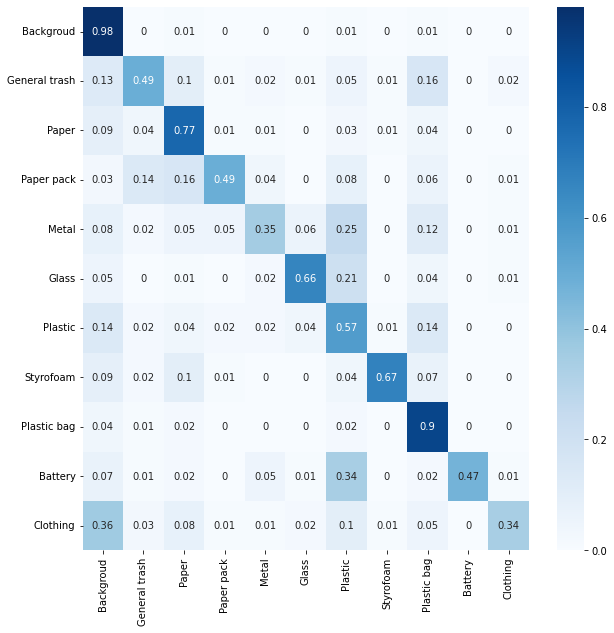

In [10]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--archi', type=str, default='unet')
# parser.add_argument('--backbone', type=str, default='efficientnet-b0')
# parser.add_argument('--pretrained_weights', type=str, default='imagenet')
# args = parser.parse_args()

# model = SmpModel(args)



mIoU, mIoU_best10, mIoU_best10_imageid, mIoU_worst10, mIoU_worst10_imageid = main(model, val_path, mode = 'train')
# plot_examples(mode="val",data_dir=val_path,image_id = mIoU_best10_imageid,image_save_path = 'save_best_mIoU10')
# plot_examples(mode="val",data_dir=val_path,image_id = mIoU_worst10_imageid,image_save_path = 'save_worst_mIoU10')
# plot_examples(mode="val",data_dir=val_path,image_id = None,image_save_path = 'train_random_sample_10')
# plot_examples(mode="test",data_dir=test_path,image_id = None,image_save_path = 'test_random_sample_10')

# inputs = torch.randn(1, 3, 512, 512)
# summary(model, (inputs.shape))
# print()